# Data exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os, sys
import contextlib
import random
from IPython.display import HTML

sys.path.append(os.path.join(os.getcwd(), 'utils'))

from utils_2.data_loading_2 import *
from utils_2.data_processing_2 import *
from utils_2.regression_2 import *
from utils_2.animation_2 import *
from utils_2.metrics_2 import *
from utils_2.pipeline_2 import *

# autoreload
%reload_ext autoreload
%autoreload 2

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data... also removing the latitudes above 60 degrees...


100%|██████████| 72/72 [00:00<00:00, 24194.03it/s]

ICON-ESM-LR r1i1p1f1
Data has shape: (165, 60, 144)
Data filtered. Kept 34 models
Creating NaN mask...



100%|██████████| 34/34 [00:01<00:00, 21.93it/s]

NaN mask created.
Masking out NaN values...



100%|██████████| 34/34 [00:01<00:00, 25.37it/s]

NaN values masked out.
Reshaping data...



100%|██████████| 34/34 [00:03<00:00, 10.69it/s]

Data reshaped.
Adding the forced response to the data...



100%|██████████| 34/34 [00:03<00:00,  9.87it/s]

Forced response added.
Removing NaN values from the grid...



100%|██████████| 34/34 [00:01<00:00, 22.71it/s]

NaN values removed.


In [3]:
# Print the keys of the data (only the first 5)
print(f"Keys of the data: {list(data.keys())[:5]}")

Keys of the data: ['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2']


In [4]:
# Choose the key with the most runs
example_model = max(data, key=lambda k: len(data[k]))
example_model_data = data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 73 runs.


In [5]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x Latitude x Longitude)

(165, 5630)

In [6]:
nans_readded_data = readd_nans_to_grid(first_example_model_run, nan_mask, predictions=True)

Re-adding NaN values to the grid...


In [7]:
nans_readded_data = nans_readded_data.reshape(165, 60, -1)

In [8]:
nans_readded_data.shape

(165, 60, 144)

In [9]:
middle_timestamp = nans_readded_data.shape[0] // 2

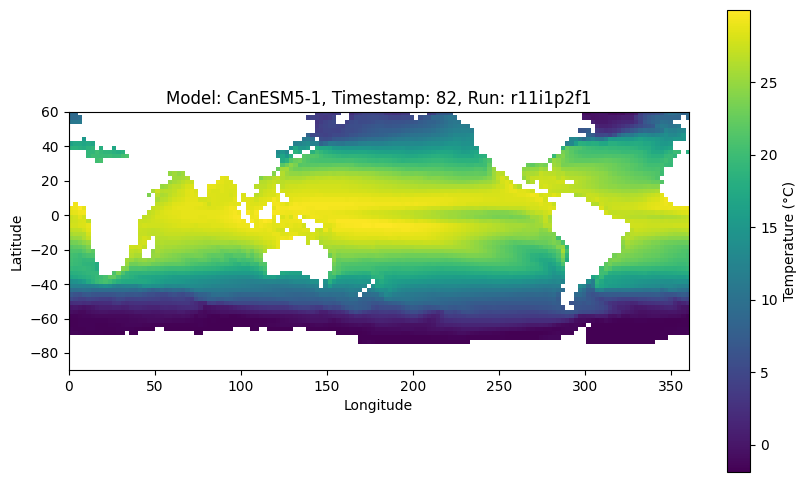

In [10]:
# Plot the data
# Create a colormap that sets NaN values to a specific color (e.g., gray)
lat_min, lat_max = -90, 60
lon_min, lon_max = 0, 360

plt.figure(figsize=(10, 6))
plt.imshow(nans_readded_data[middle_timestamp], cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max]) # Places the origin in the lower left
plt.colorbar(label='Temperature (°C)')
plt.title(f'Model: {example_model}, Timestamp: {middle_timestamp}, Run: {list(example_model_data.keys())[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Get a mask of all the grids where there is at least one NaN value (for all models and all runs)

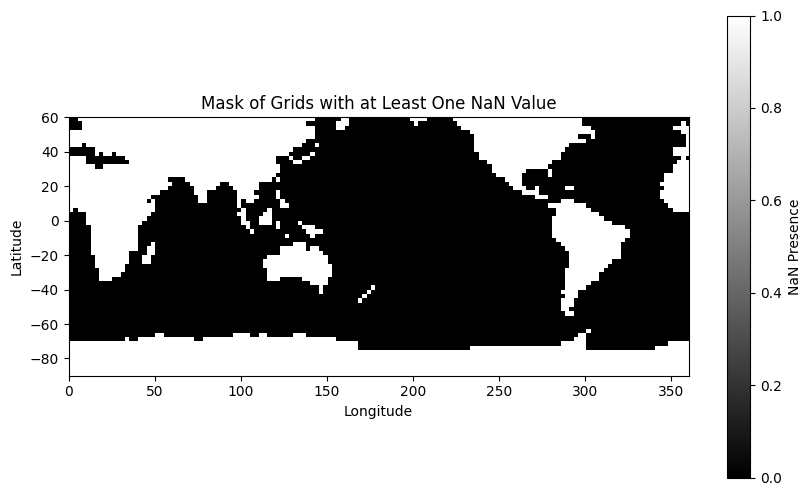

In [11]:
# Plot the mask
plt.figure(figsize=(10, 6))
plt.imshow(nan_mask, cmap='gray',extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='NaN Presence')
plt.title('Mask of Grids with at Least One NaN Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
# Center the training data and select a test model
models = list(data.keys())
test_model = random.choice(models)
train_models = [model for model in models if model != test_model]
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

# Normalize the data
normalized_train_data, normalized_test_data, _, testing_statistics = normalize_data(train_data, test_data, center=True, option=1)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 22.20it/s]

Data normalization completed.


In [13]:
print(f"Training models: {train_models}")
print(f"Test model: {test_model}")

Training models: ['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2']
Test model: GISS-E2-2-G


In [14]:
example_model_data = normalized_train_data[example_model]
first_run = list(example_model_data.keys())[0]
first_run_data = example_model_data[first_run]
print(f"First run shape: {first_run_data.shape}")

First run shape: (165, 5630)


In [15]:
normalized_plotting_data = readd_nans_to_grid(first_run_data, nan_mask, predictions=True)

Re-adding NaN values to the grid...


In [16]:
normalized_plotting_data = normalized_plotting_data.reshape(165, 60, -1)

In [17]:
print(f"Normalized plotting data shape: {normalized_plotting_data.shape}")

Normalized plotting data shape: (165, 60, 144)


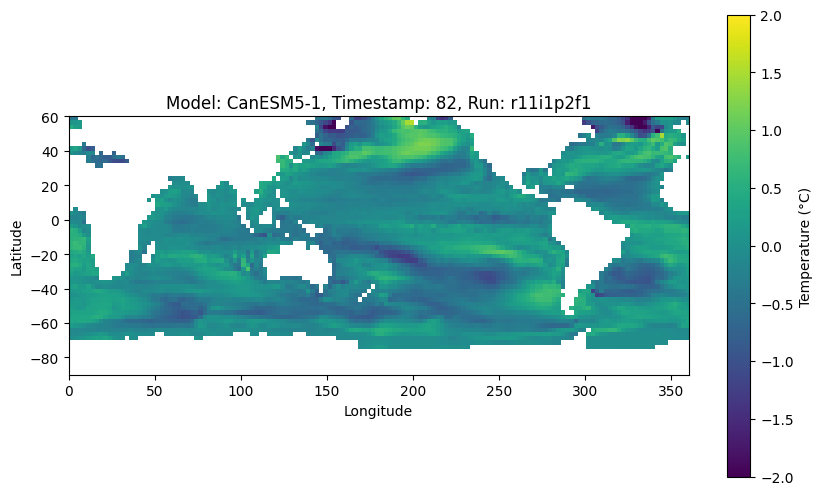

In [18]:
# Plot the data
# Create a colormap that sets NaN values to a specific color (e.g., gray)
lat_min, lat_max = -90, 60
lon_min, lon_max = 0, 360

vmin = -2
vmax = 2

plt.figure(figsize=(10, 6))
plt.imshow(normalized_plotting_data[10], cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], vmin = vmin, vmax = vmax) # Places the origin in the lower left
plt.colorbar(label='Temperature (°C)')
plt.title(f'Model: {example_model}, Timestamp: {middle_timestamp}, Run: {list(example_model_data.keys())[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Plot 3 timestamps in a row

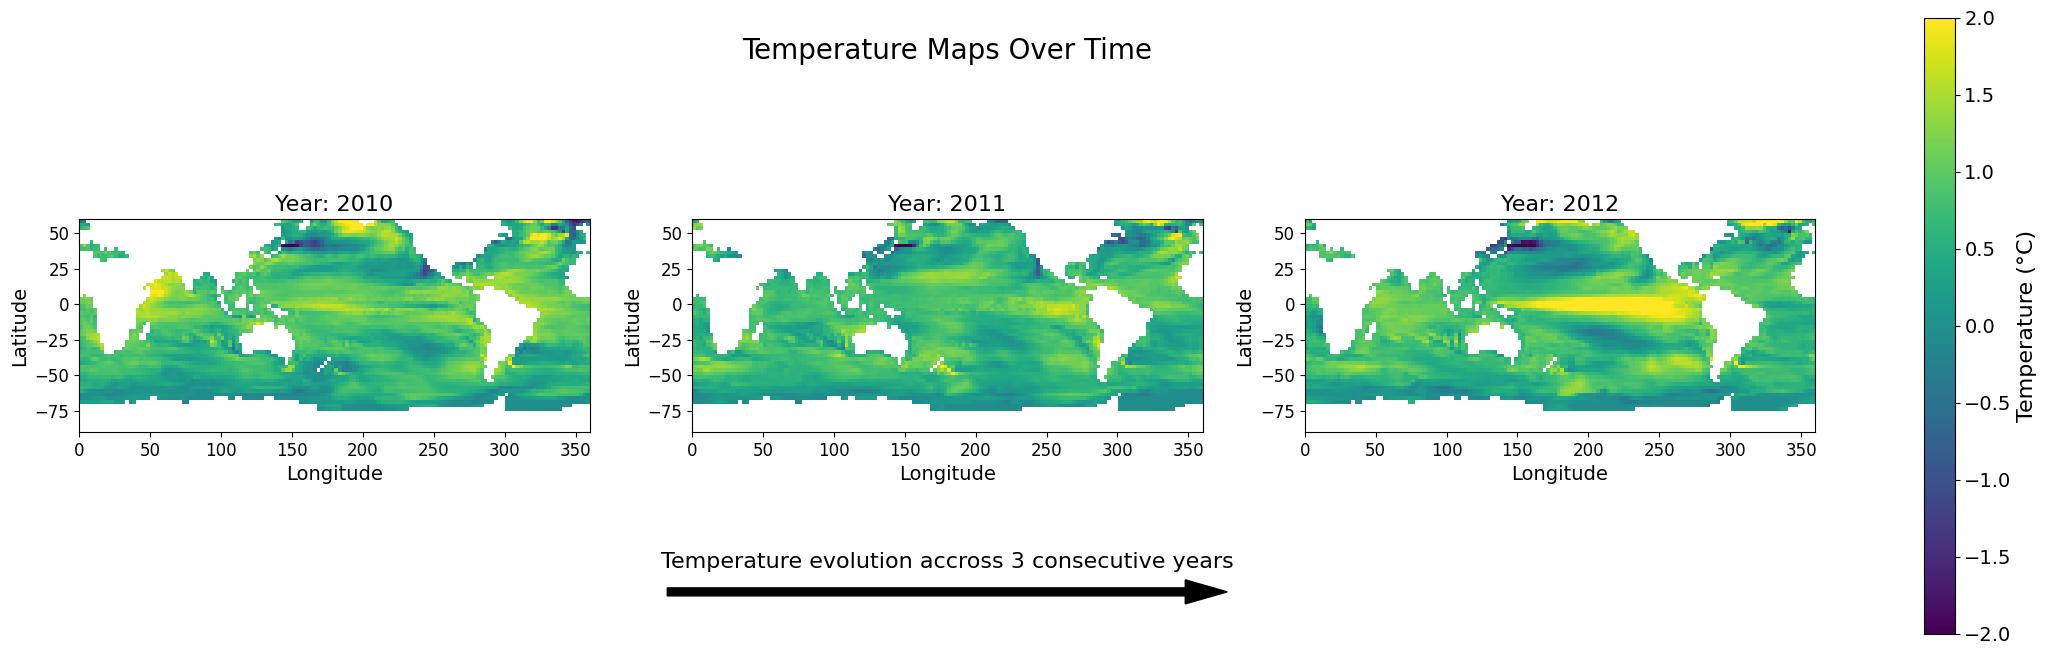

In [19]:
# Plot the maps for 3 consecutive timestamps with an arrow indicating time progression and a global title
lat_min, lat_max = -90, 60
lon_min, lon_max = 0, 360

# Ensure the output directory exists
output_dir = os.path.join(current_dir, 'report_outputs')
os.makedirs(output_dir, exist_ok=True)

# Plot the maps for 3 consecutive timestamps
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
start_timestamp = 160  # Example starting timestamp
timestamps = [start_timestamp, start_timestamp + 1, start_timestamp + 2]  # Consecutive timestamps

for i, timestamp in enumerate(timestamps):
    ax = axes[i]
    im = ax.imshow(normalized_plotting_data[timestamp], cmap='viridis', extent=[lon_min, lon_max, lat_min, lat_max], vmin=vmin, vmax=vmax)
    ax.set_title(f'Year: {1850+timestamp}', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(labelsize=12)

# Add a colorbar
# fig.colorbar(im, ax=axes, orientation='vertical', label='Temperature (°C)')
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')
cbar.set_label('Temperature (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Add a global title
# fig.suptitle('Temperature Maps for Consecutive Timestamps', fontsize=16)
# Get the middle subplot position to place the title above it
mid_ax = axes[1]
mid_ax_pos = mid_ax.get_position()
title_x = (mid_ax_pos.x0 + mid_ax_pos.x1) / 2
title_y = mid_ax_pos.y1 + 0.20  # Slightly above the top of the middle axis

# Add the global title centered over the middle subplot
fig.text(title_x, title_y, 'Temperature Maps Over Time', ha='center', fontsize=20)

# Arrow positioned below second subplot
arrow_y = mid_ax_pos.y0 - 0.2
arrow_length = 0.2  # reasonable width for clarity

arrow = patches.FancyArrow(
    (mid_ax_pos.x0 + mid_ax_pos.x1) / 2 - arrow_length / 2, arrow_y,
    arrow_length, 0, width=0.01,
    head_width=0.03, head_length=0.015,
    length_includes_head=True,
    color='black',
    transform=fig.transFigure
)
fig.patches.append(arrow)

# Text above the arrow
fig.text((mid_ax_pos.x0 + mid_ax_pos.x1) / 2, arrow_y + 0.03, 'Temperature evolution accross 3 consecutive years', ha='center', fontsize=16)


# Save the figure
output_path = os.path.join(output_dir, 'map_consecutive_timestamps_with_arrow.png')
plt.savefig(output_path)
plt.show()

In [20]:
# Readd the NaNs to the grid for all runs and all models
readded_data = {}
for model, runs in normalized_train_data.items():
    readded_data[model] = {}
    for run, data in runs.items():
        with open(os.devnull, 'w') as fnull: # Redirect the stdout to avoid printing the progress
            with contextlib.redirect_stdout(fnull):
                readded_data[model][run] = readd_nans_to_grid(data, nan_mask, predictions=True)

Displaying the forced response and runs for grid spot: [  9 134]


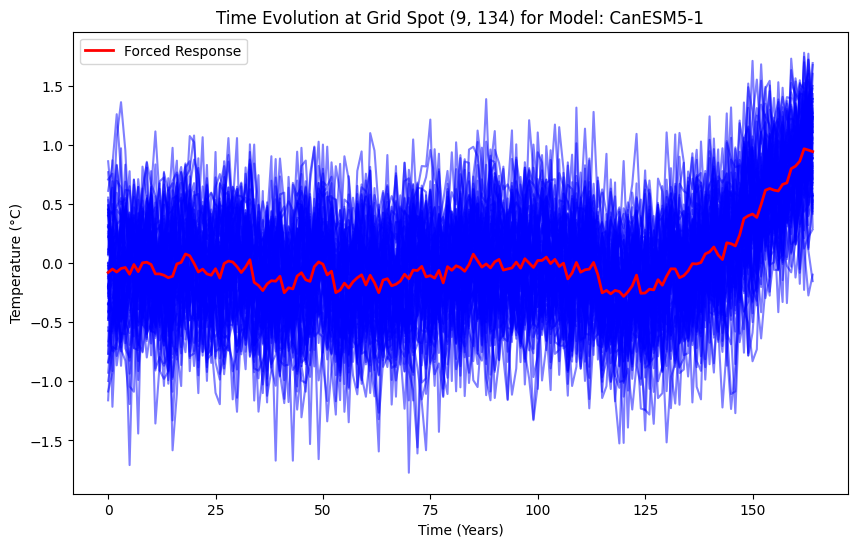

In [21]:
# Example of plotting the forced response for a random model
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run
time_series_data = {run: readded_data[example_model][run].reshape(165, 60, 144)[:, random_grid_spot[0], random_grid_spot[1]] for run in readded_data[example_model]}
forced_response_data = readded_data[example_model]['forced_response'].reshape(165, 60, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs and the forced response
plt.figure(figsize=(10, 6))
for data in time_series_data.values():
    plt.plot(data, color='blue', alpha=0.5)
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {example_model}')
plt.xlabel('Time (Years)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

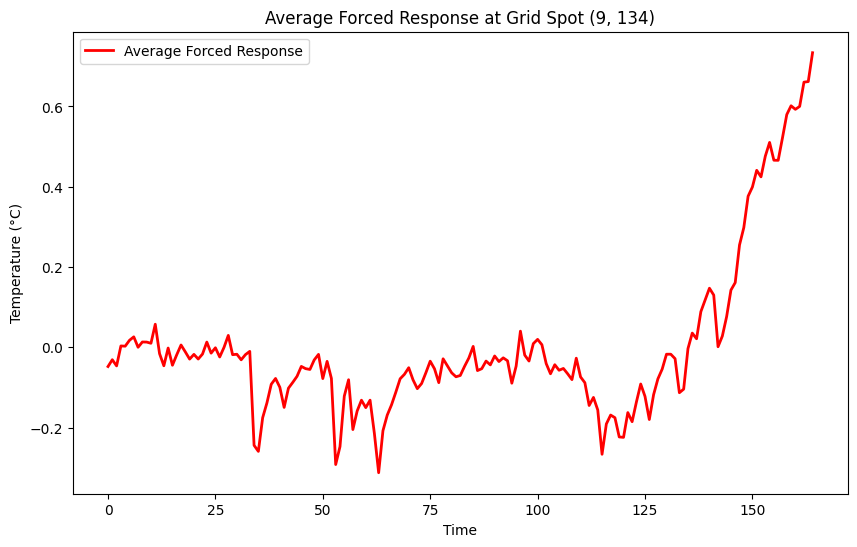

In [22]:
# Plot the average forced response of all models for that given grid spot
average_forced_response = np.mean([readded_data[model]['forced_response'].reshape(165, 60, 144)[:, random_grid_spot[0], random_grid_spot[1]] for model in readded_data], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(average_forced_response, color='red', label='Average Forced Response', linewidth=2)
plt.title(f'Average Forced Response at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]})')
plt.xlabel('Time') # Need to change this
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [25]:
# Create the animation
title = 'Ground Truth Data over Time'
color_limits = [-2,+2]
# save_path = os.path.join(os.getcwd(), 'animations', 'ground_truth_animation.gif') # to save as a gif
save_path = os.path.join(current_dir, 'animations/Data_exploration', 'ground_truth_animation_yeet.mp4') # to save as a mp4
animation = animate_data(normalized_plotting_data, title, interval = 200, cmap='viridis', color_limits=color_limits)

# Display the animation
display(HTML(animation.to_html5_video()))

# Save the animation in the path
animation.save(save_path, writer = 'ffmpeg', fps=10) # to save as a mp4